In [326]:
import matplotlib.pyplot as plt
import pandas  as pd
import numpy   as np
import xgboost as xgb

In [327]:
dg_df = pd.read_csv('./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/Demographics.csv')
dg_df.head(16)

,ID,Gender,HbA1c
0,13,MALE,5.7
1,1,FEMALE,5.5
2,3,FEMALE,5.9
3,4,FEMALE,6.4
4,5,FEMALE,5.7
5,2,MALE,5.6
6,6,FEMALE,5.8
7,7,FEMALE,5.3
8,8,FEMALE,5.6
9,10,FEMALE,6.0


In [328]:
df = pd.read_csv(r'./features.csv', sep='\t', encoding='utf-8')

In [329]:
df = df.dropna().drop(columns=['Unnamed: 0']).reset_index(drop=True)

In [330]:
df.isna().sum()

calories2hr       0
protein2hr        0
sugar2hr          0
carbs2hr          0
calories8hr       0
                 ..
datetime          0
ID                0
HbA1c             0
Biological Sex    0
label             0
Length: 83, dtype: int64

In [331]:
df['Biological Sex'] = df['Biological Sex'].map({'FEMALE': 0, 'MALE': 1})

In [332]:
df['label'] = df['label'].map({'PersLow': 0, 'PersNorm': 1, 'PersHigh':2})

In [333]:
corrdf = df.drop(columns=['datetime']).corr()

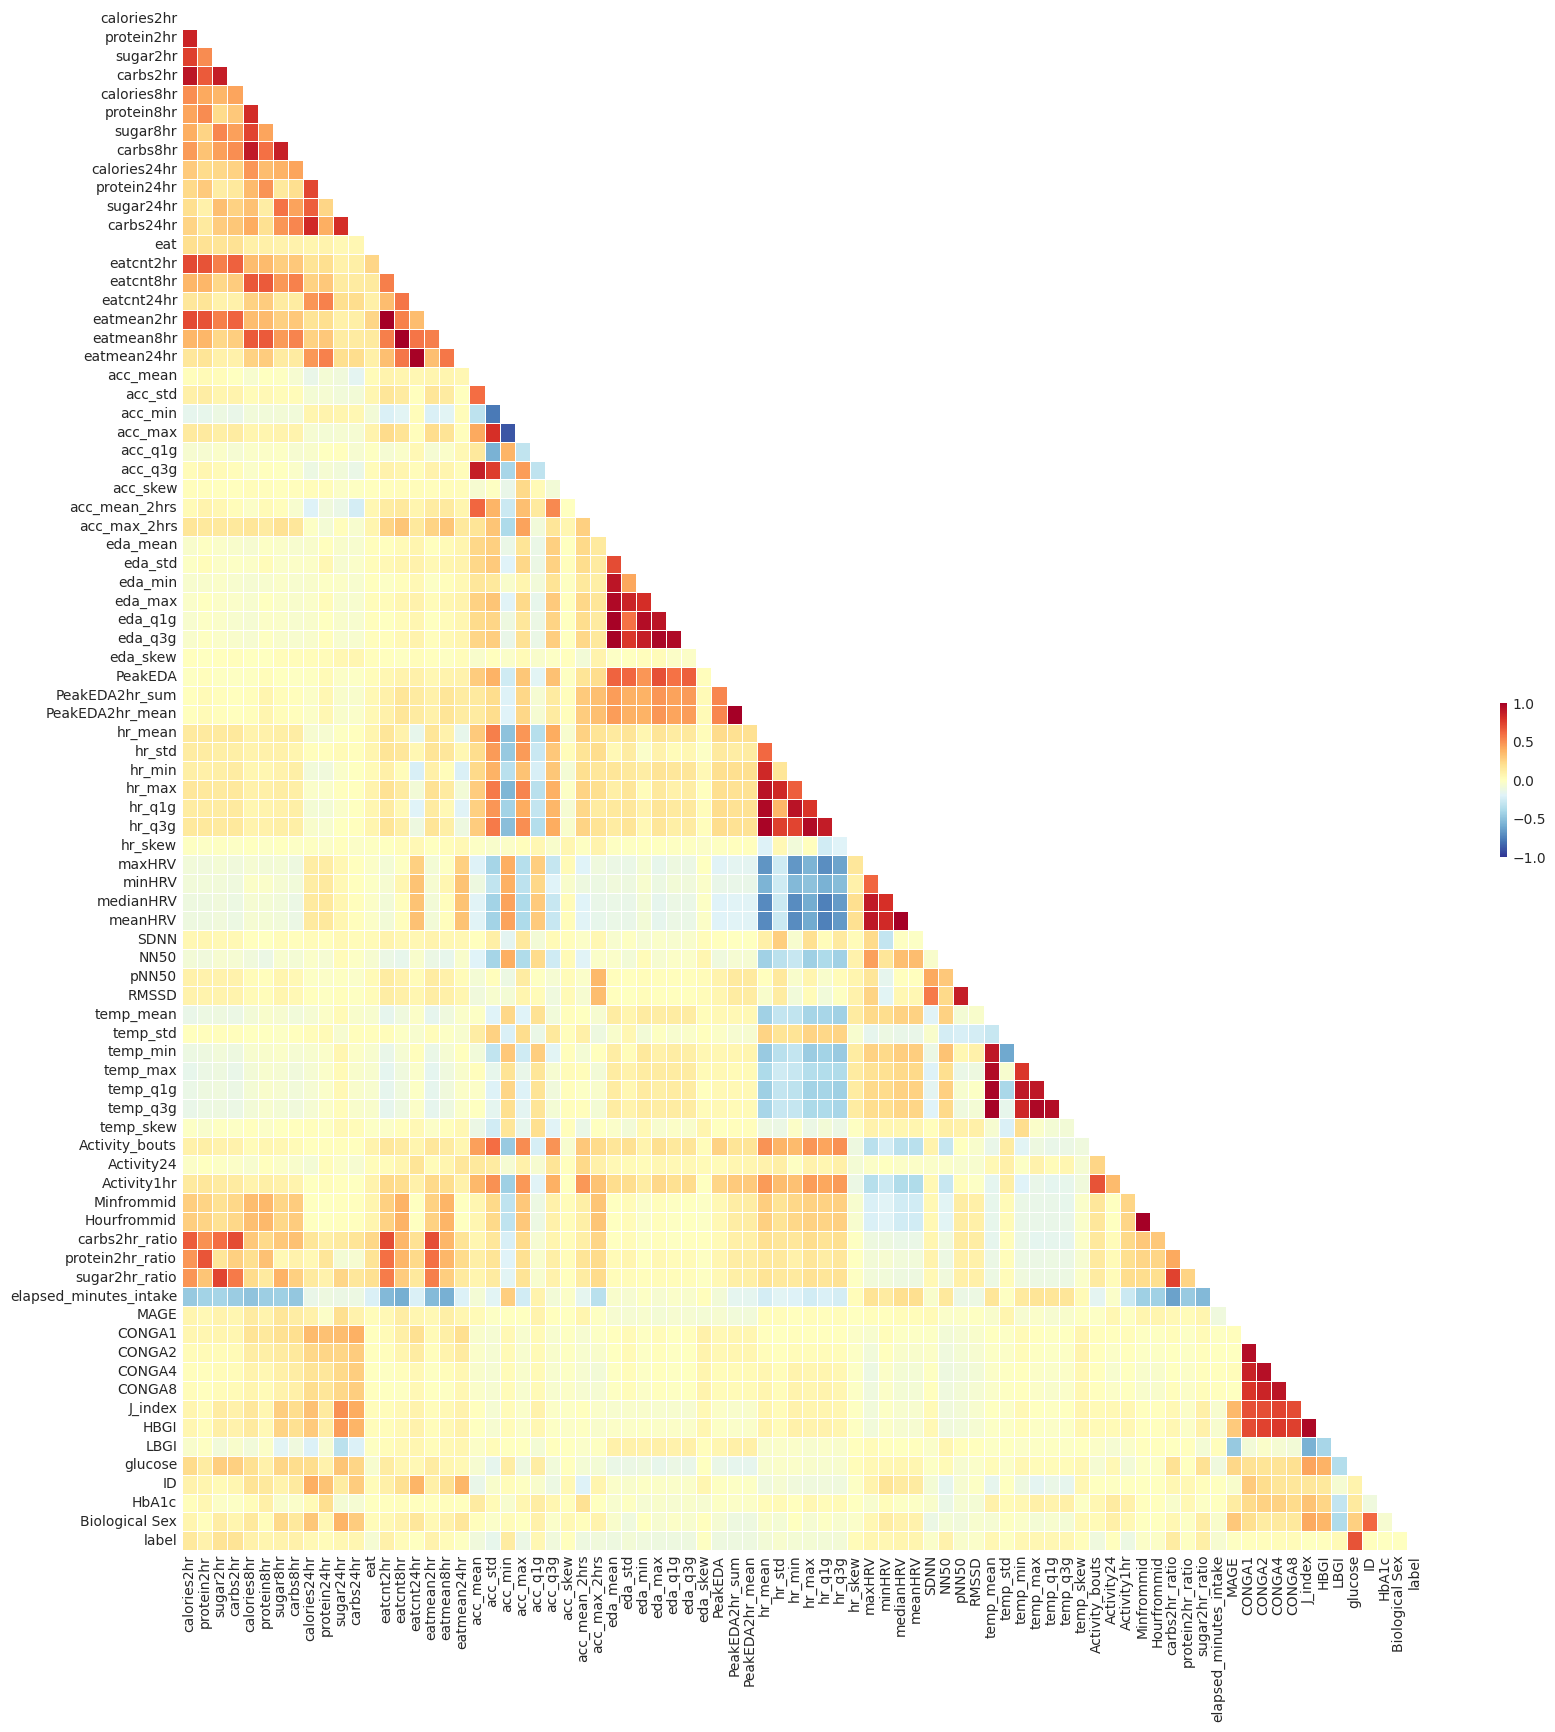

In [334]:
import seaborn as sns

# 그림 사이즈 지정
fig, ax = plt.subplots( figsize=(20,20) )

mask = np.zeros_like(corrdf)
mask[np.triu_indices_from(mask)] = True

# 히트맵을 그린다
sns.heatmap(corrdf, 
            cmap = 'RdYlBu_r', 
            annot = False,   # 실제 값을 표시한다
            mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .1},# 컬러바 크기 줄이기
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           )  
plt.show()

## 1. 독립적 교차 검증(subject-independent cross-validation), LOSO(Leave-One-Subject-Out) Model

In [335]:
def XGBLOSO(data, ids, outcomevar, dropcols, idcolumn, numestimators=1000):
    """
        Intermediate function. 
    """
    # Get important features
    #listimportances = LOOCV_featureselection(data, ids, outcomevar, dropcols, idcolumn, numestimators)
    #filteredi = listimportances[listimportances['importances'] < fs]
    #filteredi = filteredi['value']
    
    LOOCV_O = int(float(ids))
    data.loc[:,idcolumn] = data.loc[:,idcolumn].apply(int)
    data_filtered = data[data[idcolumn] != LOOCV_O]
    data_cv = data[data[idcolumn] == LOOCV_O]

    print(f'LOOCV_O : {LOOCV_O}')
    
    # Test data - the person left out of training
    data_test = data_cv.drop(columns=dropcols)
    #data_test = data_test.drop(columns=filteredi) #cvf
    X_test = data_test.drop(columns=[outcomevar])
    y_test = data_test[outcomevar] #This is the outcome variable

    #X_test.loc[:, idcolumn] = X_test.loc[:, idcolumn].astype(pd.to_numeric)
    
    # Train data - all other people in dataframe
    data_train = data_filtered.drop(columns=dropcols)
    #data_train = data_train.drop(columns=filteredi)
    X_train = data_train.drop(columns=[outcomevar])

    feature_list = list(X_train.columns)
    #X_train= X_train
    y_train = data_train[outcomevar]

    #X_train.loc[:, idcolumn] = X_train.loc[:, idcolumn].astype(pd.to_numeric)


    # XGBoost Regressor with fixed parameters
    xgbr = xgb.XGBRegressor(
        n_estimators=numestimators,
        max_depth=6,
        learning_rate=0.1,
        random_state=0,
        enable_categorical=True
    )
    print('Now processing... XGBoost - Leave One Subject Out')
    xgbr.fit(X_train, y_train)
    
    test_predictions = xgbr.predict(X_test)
    train_predictions = xgbr.predict(X_train)
    errors = abs(test_predictions - y_test)

    # Root Mean Squared Error (RMSE)
    from sklearn import metrics
    RMSE = np.sqrt(metrics.mean_squared_error(y_test, test_predictions))
    test_rmse = RMSE
    train_rmse = np.sqrt(metrics.mean_squared_error(y_train, train_predictions))
    
    # Mean Average Percent Error (MAPE)
    MAPerror = np.mean(np.abs((y_test - test_predictions) / y_test)) * 100 
    test_mape = MAPerror
    train_mape = np.mean(np.abs((y_train - train_predictions) / y_train)) * 100 
    
    # List of tuples with variable and importance
    importances = list(xgbr.feature_importances_)
    important = pd.DataFrame()
    important['value'] = feature_list
    important['importances'] = importances
    important['id'] = str(ids)
    
    return train_rmse, test_rmse, train_mape, test_mape, errors, RMSE, MAPerror, important

def losoXGB(data, idcolumn, outcomevar, dropcols=[], numestimators=1000):
    """
        Main LOSO XGB function that calls other functions to do XGB training, and testing. 

        Args:
          
        Returns:
    """
    
    # Make list of all ID's in idcolumn
    IDlist = list(data[idcolumn].astype(str).unique())
    print(f'IDlist : {IDlist}')
    drop = [] #drop = [idcolumn]
    drop = drop + dropcols
    
    # Initialize empty lists and dataframe 
    errors = []
    rmse = []
    mape = []
    importances = pd.DataFrame(columns=['value', 'importances', 'id'])
    rmse_df = pd.DataFrame(columns=['train_rmse','test_rmse', 'id'])
    mape_df = pd.DataFrame(columns=['train_mape','test_mape', 'id'])
    acc_df = pd.DataFrame(columns=['train_acc','test_acc', 'id'])
    
    # Run LOOCV Random Forest! 
    for i in IDlist:
        train_rmse, test_rmse, train_mape, test_mape, er, rm, ma, imp= XGBLOSO(data, i, outcomevar, drop, idcolumn, numestimators)
        rmse_row = pd.DataFrame({'train_rmse': [train_rmse], 'test_rmse': [test_rmse], 'id': [str(i)]})
        rmse_df = pd.concat([rmse_df, rmse_row], ignore_index=True)
        mape_row = pd.DataFrame({'train_mape': [train_mape], 'test_mape': [test_mape], 'id': [str(i)]})
        mape_df = pd.concat([mape_df, mape_row], ignore_index=True)
        acc_row = pd.DataFrame({'train_acc': [100 - train_mape], 'test_acc': [100 - test_mape], 'id': [str(i)]})
        acc_df = pd.concat([acc_df, acc_row], ignore_index=True)
        errors.append(er)
        rmse.append(rm)
        mape.append(ma)
        #eval = pd.DataFrame({'rmse': [rm], 'mape': [ma], 'id': [str(i)]})
        #eval_metrics = pd.concat([eval_metrics, eval], ignore_index=True)
        importances = pd.concat([importances, imp], ignore_index=True)
        idt = str(i)
        print('...' + idt + ' processing complete.')

    # Compute mean and std RMSE, MAPE
    meanrmse = np.mean(rmse)
    stdrmse = np.std(rmse)
    meanmape = np.mean(mape)
    stdmape = np.std(mape)
    
    # Print RMSE, MAPE
    print('Mean RMSE:' + str(meanrmse))
    print('Std RMSE:' + str(stdrmse))
    print('Mean MAPE:' + str(meanmape))
    print('Std MAPE:' + str(stdmape))
    
    eval_df = rmse_df.merge(mape_df, on='id').merge(acc_df, on='id')
    
    #TODO: 파라미터들을 담은 dataframe을 반환하도록 할 것.
    return eval_df, errors, meanrmse, stdrmse, meanmape, stdmape, importances

In [336]:
eval_df, errors, RMSE, RMSEstd, MAPE, MAPEstd, importances = losoXGB(data=df, idcolumn='ID', outcomevar='glucose', dropcols=['label', 'datetime'], numestimators=100)

IDlist : ['1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '10.0', '11.0', '12.0', '13.0', '14.0', '16.0']
LOOCV_O : 1
Now processing... XGBoost - Leave One Subject Out


/tmp/ipykernel_3232/311991914.py:100: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rmse_df = pd.concat([rmse_df, rmse_row], ignore_index=True)
/tmp/ipykernel_3232/311991914.py:102: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mape_df = pd.concat([mape_df, mape_row], ignore_index=True)
/tmp/ipykernel_3232/311991914.py:104: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns wh

...1.0 processing complete.
LOOCV_O : 2
Now processing... XGBoost - Leave One Subject Out
...2.0 processing complete.
LOOCV_O : 3
Now processing... XGBoost - Leave One Subject Out
...3.0 processing complete.
LOOCV_O : 4
Now processing... XGBoost - Leave One Subject Out
...4.0 processing complete.
LOOCV_O : 5
Now processing... XGBoost - Leave One Subject Out
...5.0 processing complete.
LOOCV_O : 6
Now processing... XGBoost - Leave One Subject Out
...6.0 processing complete.
LOOCV_O : 7
Now processing... XGBoost - Leave One Subject Out
...7.0 processing complete.
LOOCV_O : 8
Now processing... XGBoost - Leave One Subject Out
...8.0 processing complete.
LOOCV_O : 9
Now processing... XGBoost - Leave One Subject Out
...9.0 processing complete.
LOOCV_O : 10
Now processing... XGBoost - Leave One Subject Out
...10.0 processing complete.
LOOCV_O : 11
Now processing... XGBoost - Leave One Subject Out
...11.0 processing complete.
LOOCV_O : 12
Now processing... XGBoost - Leave One Subject Out
...12

In [337]:
eval_df.head(20)

,train_rmse,test_rmse,id,train_mape,test_mape,train_acc,test_acc
0,8.974079,14.994636,1.0,5.683028,11.183397,94.316972,88.816603
1,8.857153,22.121144,2.0,5.710020,13.831838,94.289980,86.168162
2,8.852115,17.259789,3.0,5.675518,11.153073,94.324482,88.846927
3,8.946550,17.309816,4.0,5.704310,12.223575,94.295690,87.776425
4,9.285705,11.529135,5.0,5.861778,9.311641,94.138222,90.688359
5,8.674112,26.782836,6.0,5.580882,16.838137,94.419118,83.161863
6,9.122917,18.542127,7.0,5.776860,18.090828,94.223140,81.909172
7,9.250730,13.617558,8.0,5.868607,8.990912,94.131393,91.009088
8,8.843039,21.790575,9.0,5.688677,11.978466,94.311323,88.021534
9,8.901229,28.085331,10.0,5.664180,16.475384,94.335820,83.524616


In [338]:
# Compute average of RMSE
avg_train_rmse = eval_df['train_rmse'].mean()
avg_test_rmse = eval_df['test_rmse'].mean()
# Compute average of MAPE
avg_train_mape = eval_df['train_acc'].mean()
avg_test_mape = eval_df['test_acc'].mean()

In [339]:
imp_err = importances.groupby('value').std(numeric_only=True).rename(columns={'importances':'std'})

In [340]:
filteredimp = importances.groupby('value').mean(numeric_only=True).sort_values(by='importances', ascending=False)
filteredimp = pd.merge(filteredimp, imp_err, on='value')
print(filteredimp)

                 importances       std
value                                 
J_index             0.112875  0.022575
carbs2hr            0.084416  0.010855
LBGI                0.058188  0.008725
HbA1c               0.044513  0.013102
PeakEDA2hr_mean     0.032969  0.012130
...                      ...       ...
acc_mean            0.001011  0.000295
eat                 0.000641  0.000550
eatmean8hr          0.000000  0.000000
eatmean2hr          0.000000  0.000000
eatmean24hr         0.000000  0.000000

[80 rows x 2 columns]


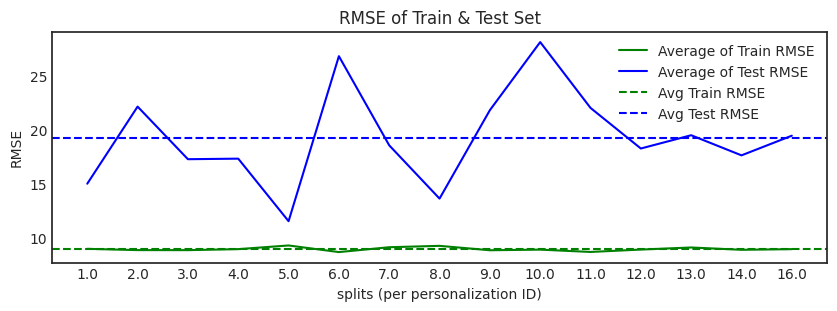

In [341]:
# 그래프 그리기
plt.figure(figsize=(10, 3))
plt.plot(eval_df['id'], eval_df['train_rmse'], 'g', label='Average of Train RMSE')
plt.plot(eval_df['id'], eval_df['test_rmse'], 'b', label='Average of Test RMSE')

# 가로 점선 추가
plt.axhline(y=avg_train_rmse, color='g', linestyle='--', label='Avg Train RMSE')
plt.axhline(y=avg_test_rmse, color='b', linestyle='--', label='Avg Test RMSE')

plt.title('RMSE of Train & Test Set')
plt.xlabel('splits (per personalization ID)')
plt.ylabel('RMSE')
plt.legend()

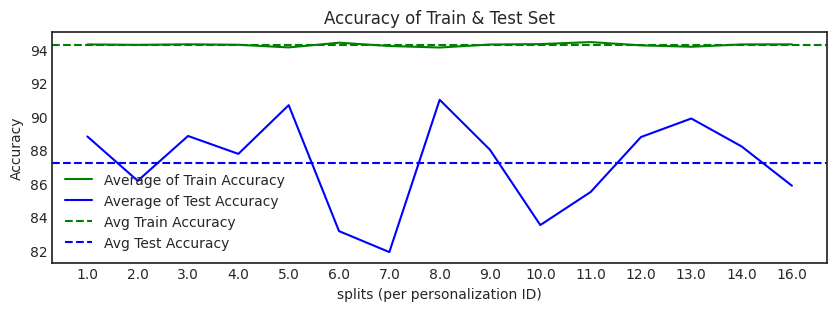

In [342]:
# 그래프 그리기
plt.figure(figsize=(10, 3))
plt.plot(eval_df['id'], eval_df['train_acc'], 'g', label='Average of Train Accuracy')
plt.plot(eval_df['id'], eval_df['test_acc'], 'b', label='Average of Test Accuracy')

# 가로 점선 추가
plt.axhline(y=avg_train_mape, color='g', linestyle='--', label='Avg Train Accuracy')
plt.axhline(y=avg_test_mape, color='b', linestyle='--', label='Avg Test Accuracy')

plt.title('Accuracy of Train & Test Set')
plt.xlabel('splits (per personalization ID)')
plt.ylabel('Accuracy')
plt.legend()

/tmp/ipykernel_3232/2107135607.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


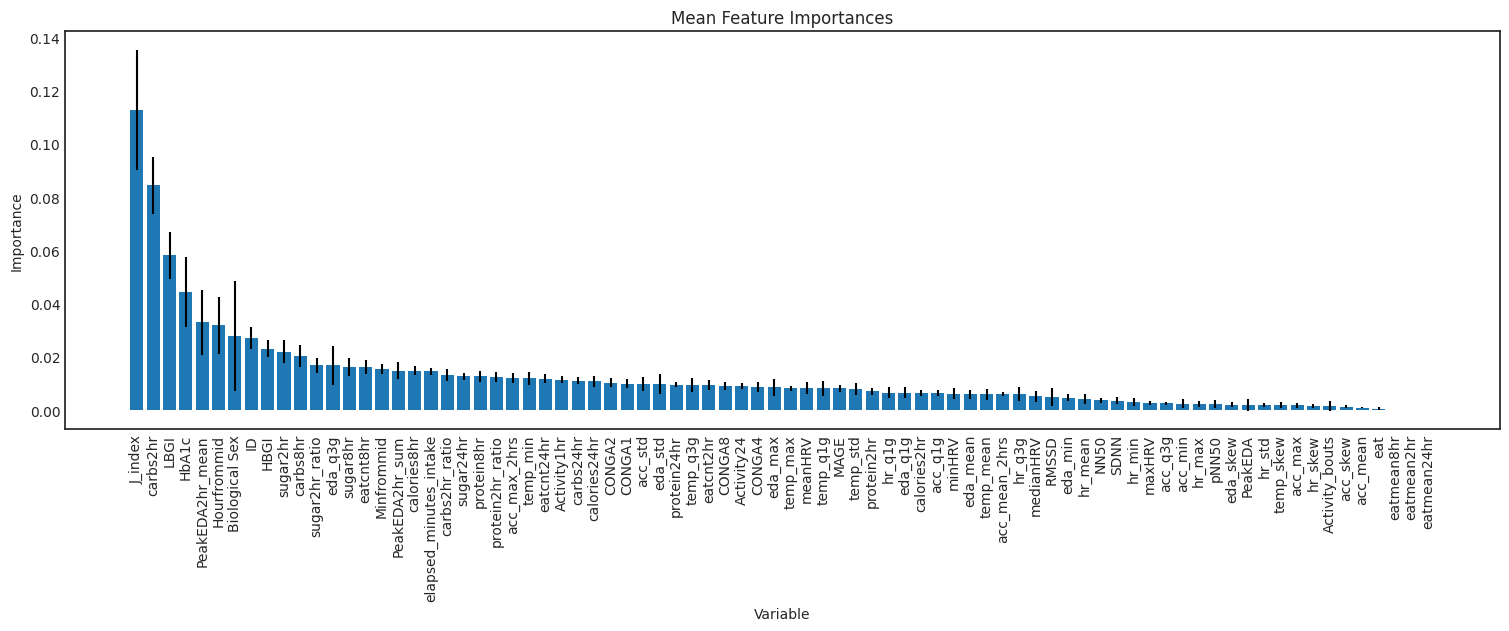

In [343]:
plt.style.use('seaborn-white')
plt.figure(figsize=(15, 6))
x_values = list(range(len(filteredimp['importances'])))
# Make a bar chart
plt.bar(x_values, filteredimp['importances'], orientation = 'vertical', yerr=filteredimp['std'])# Tick labels for x axis
plt.xticks(x_values, filteredimp.index, rotation='vertical')# Axis labels and title
plt.tight_layout()
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title(('Mean Feature Importances'))
plt.show()

## 3. 부분 개인화 교차 검증(partial personalization cross-validation) Model

In [349]:
def XGBPartialPersonalization(data, ids, outcomevar, dropcols, idcolumn, numestimators=1000, personalization_train_percent=0.5):
    """
        Intermediate function. 
    """
    # Get important features
    #listimportances = LOOCV_featureselection(data, ids, outcomevar, dropcols, idcolumn, numestimators)
    #filteredi = listimportances[listimportances['importances'] < fs]
    #filteredi = filteredi['value']
    
    LOOCV_O = int(float(ids))
    data.loc[:,idcolumn] = data.loc[:,idcolumn].apply(int)
    data_filtered = data[data[idcolumn] != LOOCV_O]
    data_cv = data[data[idcolumn] == LOOCV_O]

    print(f'LOOCV_O : {LOOCV_O}')

    train_cnt = int(len(data_cv) * personalization_train_percent)
    person_split_train = data_cv.iloc[:train_cnt]
    person_split_test = data_cv.iloc[train_cnt:]
    
    # Test data - the person left out of training
    data_test = person_split_test
    data_test = data_test.drop(columns=dropcols)
    #data_test = data_test.drop(columns=filteredi) #cvf
    X_test = data_test.drop(columns=[outcomevar])
    y_test = data_test[outcomevar] #This is the outcome variable

    #X_test.loc[:, idcolumn] = X_test.loc[:, idcolumn].astype(pd.to_numeric)
    
    # Train data - all other people in dataframe
    data_filtered = pd.concat([person_split_train, data_filtered], ignore_index=True)
    data_train = data_filtered.drop(columns=dropcols)
    #data_train = data_train.drop(columns=filteredi)
    X_train = data_train.drop(columns=[outcomevar])

    feature_list = list(X_train.columns)
    #X_train= X_train
    y_train = data_train[outcomevar]

    #X_train.loc[:, idcolumn] = X_train.loc[:, idcolumn].astype(pd.to_numeric)


    # XGBoost Regressor with fixed parameters
    xgbr = xgb.XGBRegressor(
        n_estimators=numestimators,
        max_depth=6,
        learning_rate=0.1,
        random_state=0,
        enable_categorical=True
    )
    print('Now processing... XGBoost - Leave One Subject Out')
    xgbr.fit(X_train, y_train)
    
    test_predictions = xgbr.predict(X_test)
    train_predictions = xgbr.predict(X_train)
    errors = abs(test_predictions - y_test)

    # Root Mean Squared Error (RMSE)
    from sklearn import metrics
    RMSE = np.sqrt(metrics.mean_squared_error(y_test, test_predictions))
    test_rmse = RMSE
    train_rmse = np.sqrt(metrics.mean_squared_error(y_train, train_predictions))
    
    # Mean Average Percent Error (MAPE)
    MAPerror = np.mean(np.abs((y_test - test_predictions) / y_test)) * 100 
    test_mape = MAPerror
    train_mape = np.mean(np.abs((y_train - train_predictions) / y_train)) * 100 
    
    # List of tuples with variable and importance
    importances = list(xgbr.feature_importances_)
    important = pd.DataFrame()
    important['value'] = feature_list
    important['importances'] = importances
    important['id'] = str(ids)
    
    return train_rmse, test_rmse, train_mape, test_mape, errors, RMSE, MAPerror, important

def partialPersonalizationXGB(data, idcolumn, outcomevar, dropcols=[], numestimators=1000, personalization_train_percent = 0.5):
    """
        Main LOSO XGB function that calls other functions to do XGB training, and testing. 

        Args:
          
        Returns:
    """
    
    # Make list of all ID's in idcolumn
    IDlist = list(data[idcolumn].astype(str).unique())
    print(f'IDlist : {IDlist}')
    drop = [] #drop = [idcolumn]
    drop = drop + dropcols
    
    # Initialize empty lists and dataframe 
    errors = []
    rmse = []
    mape = []
    importances = pd.DataFrame(columns=['value', 'importances', 'id'])
    rmse_df = pd.DataFrame(columns=['train_rmse','test_rmse', 'id'])
    mape_df = pd.DataFrame(columns=['train_mape','test_mape', 'id'])
    acc_df = pd.DataFrame(columns=['train_acc','test_acc', 'id'])
    
    # Run LOOCV Random Forest! 
    for i in IDlist:
        train_rmse, test_rmse, train_mape, test_mape, er, rm, ma, imp= XGBPartialPersonalization(data, i, outcomevar, drop, idcolumn, numestimators, personalization_train_percent)
        rmse_row = pd.DataFrame({'train_rmse': [train_rmse], 'test_rmse': [test_rmse], 'id': [str(i)]})
        rmse_df = pd.concat([rmse_df, rmse_row], ignore_index=True)
        mape_row = pd.DataFrame({'train_mape': [train_mape], 'test_mape': [test_mape], 'id': [str(i)]})
        mape_df = pd.concat([mape_df, mape_row], ignore_index=True)
        acc_row = pd.DataFrame({'train_acc': [100 - train_mape], 'test_acc': [100 - test_mape], 'id': [str(i)]})
        acc_df = pd.concat([acc_df, acc_row], ignore_index=True)
        errors.append(er)
        rmse.append(rm)
        mape.append(ma)
        #eval = pd.DataFrame({'rmse': [rm], 'mape': [ma], 'id': [str(i)]})
        #eval_metrics = pd.concat([eval_metrics, eval], ignore_index=True)
        importances = pd.concat([importances, imp], ignore_index=True)
        idt = str(i)
        print('...' + idt + ' processing complete.')

    # Compute mean and std RMSE, MAPE
    meanrmse = np.mean(rmse)
    stdrmse = np.std(rmse)
    meanmape = np.mean(mape)
    stdmape = np.std(mape)
    
    # Print RMSE, MAPE
    print('Mean RMSE:' + str(meanrmse))
    print('Std RMSE:' + str(stdrmse))
    print('Mean MAPE:' + str(meanmape))
    print('Std MAPE:' + str(stdmape))
    
    eval_df = rmse_df.merge(mape_df, on='id').merge(acc_df, on='id')
    
    #TODO: 파라미터들을 담은 dataframe을 반환하도록 할 것.
    return eval_df, errors, meanrmse, stdrmse, meanmape, stdmape, importances

In [350]:
eval_df, errors, RMSE, RMSEstd, MAPE, MAPEstd, importances = partialPersonalizationXGB(data=df, idcolumn='ID', outcomevar='glucose', dropcols=['datetime'], numestimators=100)

IDlist : ['1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '10.0', '11.0', '12.0', '13.0', '14.0', '16.0']
LOOCV_O : 1
Now processing... XGBoost - Leave One Subject Out


/tmp/ipykernel_3232/1862686875.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rmse_df = pd.concat([rmse_df, rmse_row], ignore_index=True)
/tmp/ipykernel_3232/1862686875.py:108: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mape_df = pd.concat([mape_df, mape_row], ignore_index=True)
/tmp/ipykernel_3232/1862686875.py:110: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns

...1.0 processing complete.
LOOCV_O : 2
Now processing... XGBoost - Leave One Subject Out
...2.0 processing complete.
LOOCV_O : 3
Now processing... XGBoost - Leave One Subject Out
...3.0 processing complete.
LOOCV_O : 4
Now processing... XGBoost - Leave One Subject Out
...4.0 processing complete.
LOOCV_O : 5
Now processing... XGBoost - Leave One Subject Out
...5.0 processing complete.
LOOCV_O : 6
Now processing... XGBoost - Leave One Subject Out
...6.0 processing complete.
LOOCV_O : 7
Now processing... XGBoost - Leave One Subject Out
...7.0 processing complete.
LOOCV_O : 8
Now processing... XGBoost - Leave One Subject Out
...8.0 processing complete.
LOOCV_O : 9
Now processing... XGBoost - Leave One Subject Out
...9.0 processing complete.
LOOCV_O : 10
Now processing... XGBoost - Leave One Subject Out
...10.0 processing complete.
LOOCV_O : 11
Now processing... XGBoost - Leave One Subject Out
...11.0 processing complete.
LOOCV_O : 12
Now processing... XGBoost - Leave One Subject Out
...12

In [351]:
eval_df.head(20)

,train_rmse,test_rmse,id,train_mape,test_mape,train_acc,test_acc
0,6.215144,7.154566,1.0,4.095460,5.022195,95.904540,94.977805
1,6.221396,10.578663,2.0,4.102984,6.662548,95.897016,93.337452
2,6.300425,6.952238,3.0,4.143860,4.591894,95.856140,95.408106
3,6.260226,10.445243,4.0,4.100120,7.005639,95.899880,92.994361
4,6.268155,7.015760,5.0,4.134828,5.369203,95.865172,94.630797
5,6.076259,17.875900,6.0,4.036680,9.916861,95.963320,90.083139
6,6.175745,14.466476,7.0,4.049181,14.658846,95.950819,85.341154
7,6.222821,8.703210,8.0,4.089275,5.703608,95.910725,94.296392
8,6.154653,14.074126,9.0,4.083527,8.204827,95.916473,91.795173
9,6.164561,18.506241,10.0,4.072304,13.149162,95.927696,86.850838


In [352]:
# Compute average of RMSE
avg_train_rmse = eval_df['train_rmse'].mean()
avg_test_rmse = eval_df['test_rmse'].mean()
# Compute average of MAPE
avg_train_mape = eval_df['train_acc'].mean()
avg_test_mape = eval_df['test_acc'].mean()

In [353]:
imp_err = importances.groupby('value').std(numeric_only=True).rename(columns={'importances':'std'})

In [354]:
filteredimp = importances.groupby('value').mean(numeric_only=True).sort_values(by='importances', ascending=False)
filteredimp = pd.merge(filteredimp, imp_err, on='value')
print(filteredimp)

                importances       std
value                                
label              0.374031  0.011492
HBGI               0.113794  0.008143
LBGI               0.077997  0.011763
Biological Sex     0.060472  0.013613
J_index            0.051193  0.014871
...                     ...       ...
eat                0.000511  0.000537
Activity_bouts     0.000320  0.000712
eatmean8hr         0.000000  0.000000
eatmean24hr        0.000000  0.000000
eatmean2hr         0.000000  0.000000

[81 rows x 2 columns]


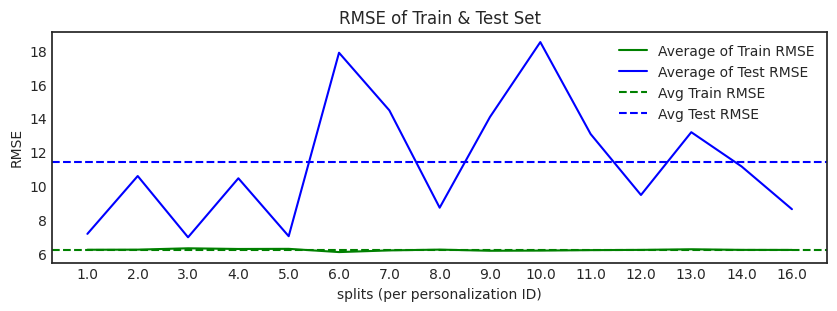

In [355]:
# 그래프 그리기
plt.figure(figsize=(10, 3))
plt.plot(eval_df['id'], eval_df['train_rmse'], 'g', label='Average of Train RMSE')
plt.plot(eval_df['id'], eval_df['test_rmse'], 'b', label='Average of Test RMSE')

# 가로 점선 추가
plt.axhline(y=avg_train_rmse, color='g', linestyle='--', label='Avg Train RMSE')
plt.axhline(y=avg_test_rmse, color='b', linestyle='--', label='Avg Test RMSE')

plt.title('RMSE of Train & Test Set')
plt.xlabel('splits (per personalization ID)')
plt.ylabel('RMSE')
plt.legend()

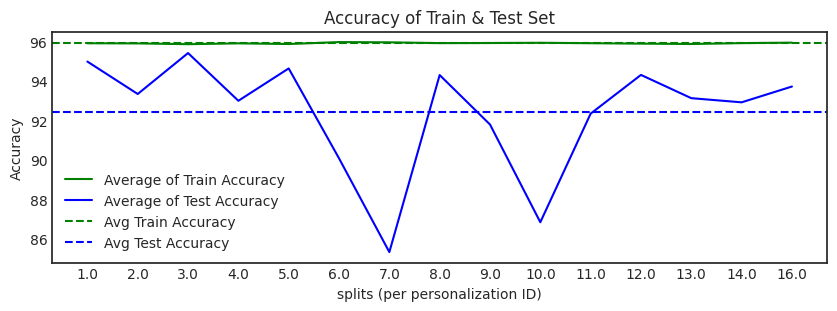

In [356]:
# 그래프 그리기
plt.figure(figsize=(10, 3))
plt.plot(eval_df['id'], eval_df['train_acc'], 'g', label='Average of Train Accuracy')
plt.plot(eval_df['id'], eval_df['test_acc'], 'b', label='Average of Test Accuracy')

# 가로 점선 추가
plt.axhline(y=avg_train_mape, color='g', linestyle='--', label='Avg Train Accuracy')
plt.axhline(y=avg_test_mape, color='b', linestyle='--', label='Avg Test Accuracy')

plt.title('Accuracy of Train & Test Set')
plt.xlabel('splits (per personalization ID)')
plt.ylabel('Accuracy')
plt.legend()